In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
import cv2
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D,Flatten,Activation, MaxPooling2D, AveragePooling2D, Dense,BatchNormalization,Add,Input,concatenate,Dropout,GlobalAveragePooling2D
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
!pip install opencv-python

In [7]:
Mild_Demented = glob.glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Mild_Demented/*.jpg')
Moderate_Demented = glob.glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Moderate_Demented/*.jpg')
Non_Demented = glob.glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Non_Demented/*.jpg')
Very_Mild_Demented = glob.glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Very_Mild_Demented/*.jpg')

data = []
labels = []

image_size=(224,224)

for i in Mild_Demented:   
    image = cv2.imread(i)
    # Resize the image
    image = cv2.resize(image, image_size)

    data.append(image)
    labels.append(0)

for i in Moderate_Demented:   
    image = cv2.imread(i)
    # Resize the image
    image = cv2.resize(image, image_size)

    data.append(image)
    labels.append(1)
    

for i in Non_Demented:   
    image = cv2.imread(i)
    # Resize the image
    image = cv2.resize(image, image_size)

    data.append(image)
    labels.append(2)
    
for i in Very_Mild_Demented:   
    image = cv2.imread(i)
    # Resize the image
    image = cv2.resize(image, image_size)

    data.append(image)
    labels.append(3)
    
X=np.array(data)
y=np.array(labels)
y.shape

(6400,)

In [26]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# Perform train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=32)

# Alzheimer data process using ResNet

In [9]:
def resnet_block(x, filters, num_blocks):
    
    if filters!=64:
        shortcut = Conv2D(filters, (1, 1), strides=(1, 1), padding='same',activation='relu')(x)
        x = Conv2D(filters,(3,3), padding='same',activation='relu')(x)
        x = Conv2D(filters,(3,3), padding='same',activation='relu')(x)
        x = BatchNormalization()(x)
        x=Add()([x, shortcut])
        num_blocks=num_blocks-1
    
    for i in range(num_blocks):
        input=x
        x = Conv2D(filters,(3,3), padding='same',activation='relu')(x)
        x = Conv2D(filters,(3,3), padding='same',activation='relu')(x)
        x = BatchNormalization()(x)
        x=Add()([x, input])
    
    return x


def resnet_34(input_shape=(224, 224, 3)):
    
    inputs = Input(shape=input_shape)
    filters = [64, 128, 256, 512]
    block_sizes = [3, 4, 6, 3]

    
    # Initial convolutional layer
    
    x = Conv2D(64, (7, 7), strides=(2, 2),padding='same',activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    for i, num_blocks in enumerate(block_sizes):
        x = resnet_block(x, filters[i], num_blocks)
    

    x = AveragePooling2D()(x)
    x = Flatten()(x)
    outputs = Dense(4, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


model = resnet_34()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 64)   0           ['conv2d[0][0]']                 
                                                                                              

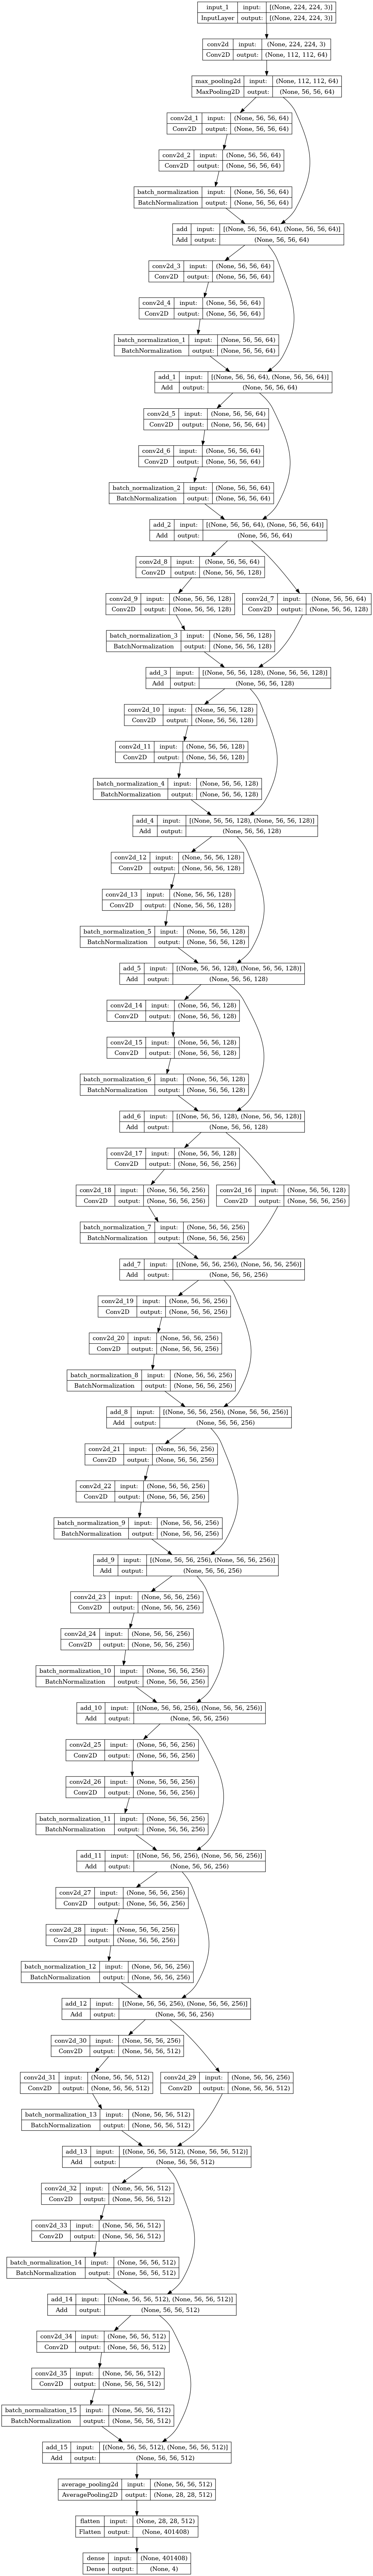

In [10]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False,
)
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [32]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history=model.fit(X_train, y_train,validation_data=(X_val,y_val),epochs=12, batch_size=55)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

Epoch 1/12
66/66 [==============================] - 128s 1s/step - loss: 5.2490 - accuracy: 0.8354 - val_loss: 49.2098 - val_accuracy: 0.5449
Epoch 2/12
66/66 [==============================] - 86s 1s/step - loss: 1.3162 - accuracy: 0.9227 - val_loss: 5.5912 - val_accuracy: 0.7956
Epoch 3/12
66/66 [==============================] - 95s 1s/step - loss: 1.5131 - accuracy: 0.9029 - val_loss: 7.1012 - val_accuracy: 0.7578
Epoch 4/12
66/66 [==============================] - 95s 1s/step - loss: 2.1710 - accuracy: 0.8898 - val_loss: 121.7591 - val_accuracy: 0.5026
Epoch 5/12
66/66 [==============================] - 86s 1s/step - loss: 1.6759 - accuracy: 0.9037 - val_loss: 51.0773 - val_accuracy: 0.5371
Epoch 6/12
66/66 [==============================] - 86s 1s/step - loss: 0.9435 - accuracy: 0.9372 - val_loss: 52.2465 - val_accuracy: 0.5456
Epoch 7/12
66/66 [==============================] - 86s 1s/step - loss: 0.7380 - accuracy: 0.9537 - val_loss: 5.4493 - val_accuracy: 0.8405
Epoch 8/12
66/

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


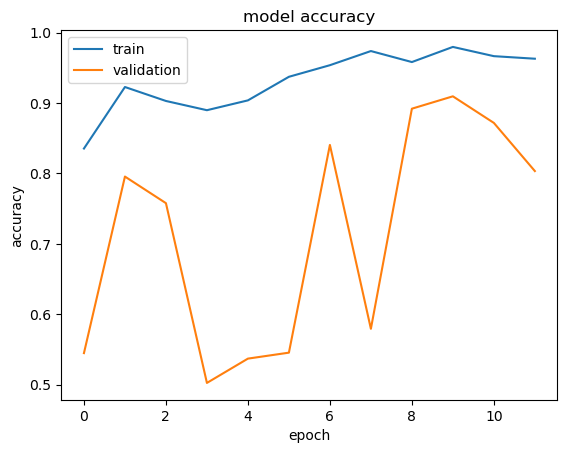

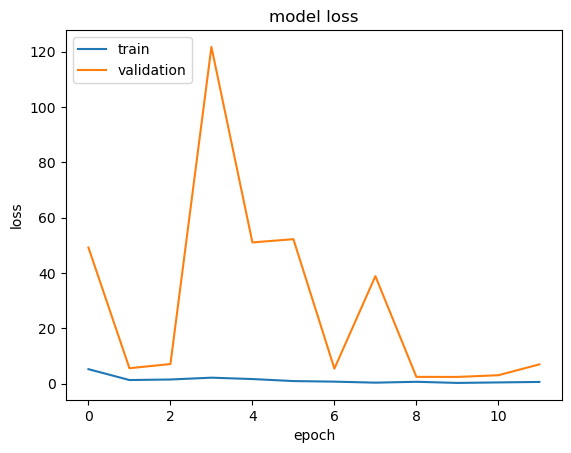

In [33]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

40/40 [==============================] - 9s 221ms/step
Classification Report:
                     precision    recall  f1-score   support

     Mild_Demented       0.91      0.42      0.57       177
 Moderate_Demented       1.00      0.92      0.96        12
      Non_Demented       0.80      0.94      0.86       648
Very_Mild_Demented       0.77      0.74      0.75       443

          accuracy                           0.80      1280
         macro avg       0.87      0.75      0.79      1280
      weighted avg       0.81      0.80      0.79      1280



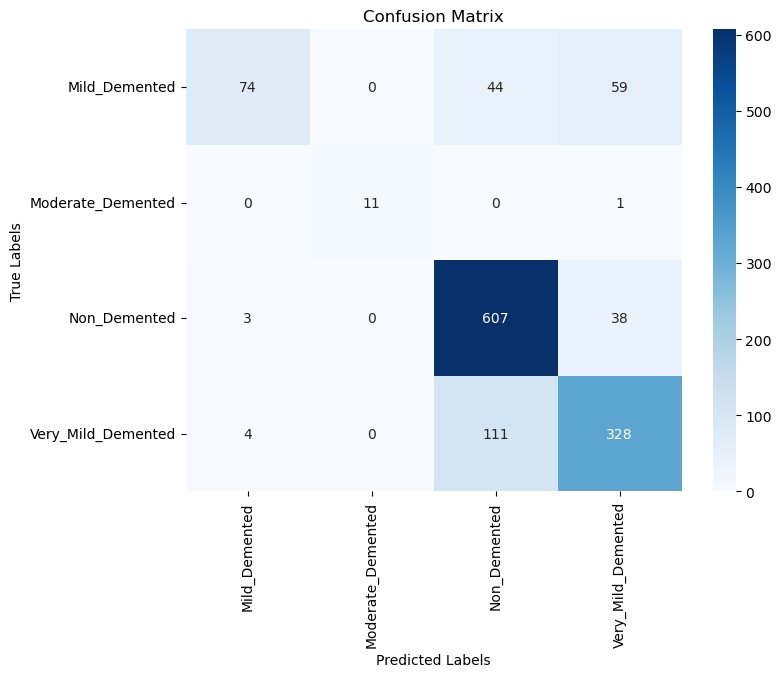

In [34]:
# Generate the classification report
class_names = list(['Mild_Demented','Moderate_Demented','Non_Demented','Very_Mild_Demented'])

# Generate the classification report
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
report = classification_report(y_test, predicted_classes, target_names=class_names)
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(y_test, predicted_classes )
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Alzheimer data process using GoogleNet

In [17]:
# Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 

    # 1st path:
    path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

    # 2nd path
    path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

    # 3rd path
    path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

    # 4th path
    path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
    path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

    output_layer = concatenate([path1, path2, path3, path4], axis = -1)

    return output_layer


def GoogLeNet():

    input_layer = Input(shape = (224, 224, 3))
    X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)
    
    X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)
    X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 1st Inception block
    X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

    # 2nd Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 3rd Inception block
    X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

    # Extra network 1:
    X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
    X1 = Flatten()(X1)
    X1 = Dense(1024, activation = 'relu')(X1)
    X1 = Dropout(0.7)(X1)
    X1 = Dense(5, activation = 'softmax')(X1)

  
    # 4th Inception block
    X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 5th Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 6th Inception block
    X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

    # Extra network 2:
    X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
    X2 = Flatten()(X2)
    X2 = Dense(1024, activation = 'relu')(X2)
    X2 = Dropout(0.7)(X2)
    X2 = Dense(1000, activation = 'softmax')(X2)
  
  
    # 7th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # 8th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

    # 9th Inception block
    X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)


    X = GlobalAveragePooling2D(name = 'GAPL')(X)
    X = Dropout(0.4)(X)
    X = Flatten()(X)

    output = Dense(4, activation = 'softmax')(X)
  
    # model
    model = Model(inputs=input_layer, outputs=output)
    return model


model2 = GoogLeNet()
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_104 (Conv2D)            (None, 109, 109, 64  9472        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_17 (MaxPooling2D  (None, 54, 54, 64)  0           ['conv2d_104[0][0]']             
 )                                                                                          

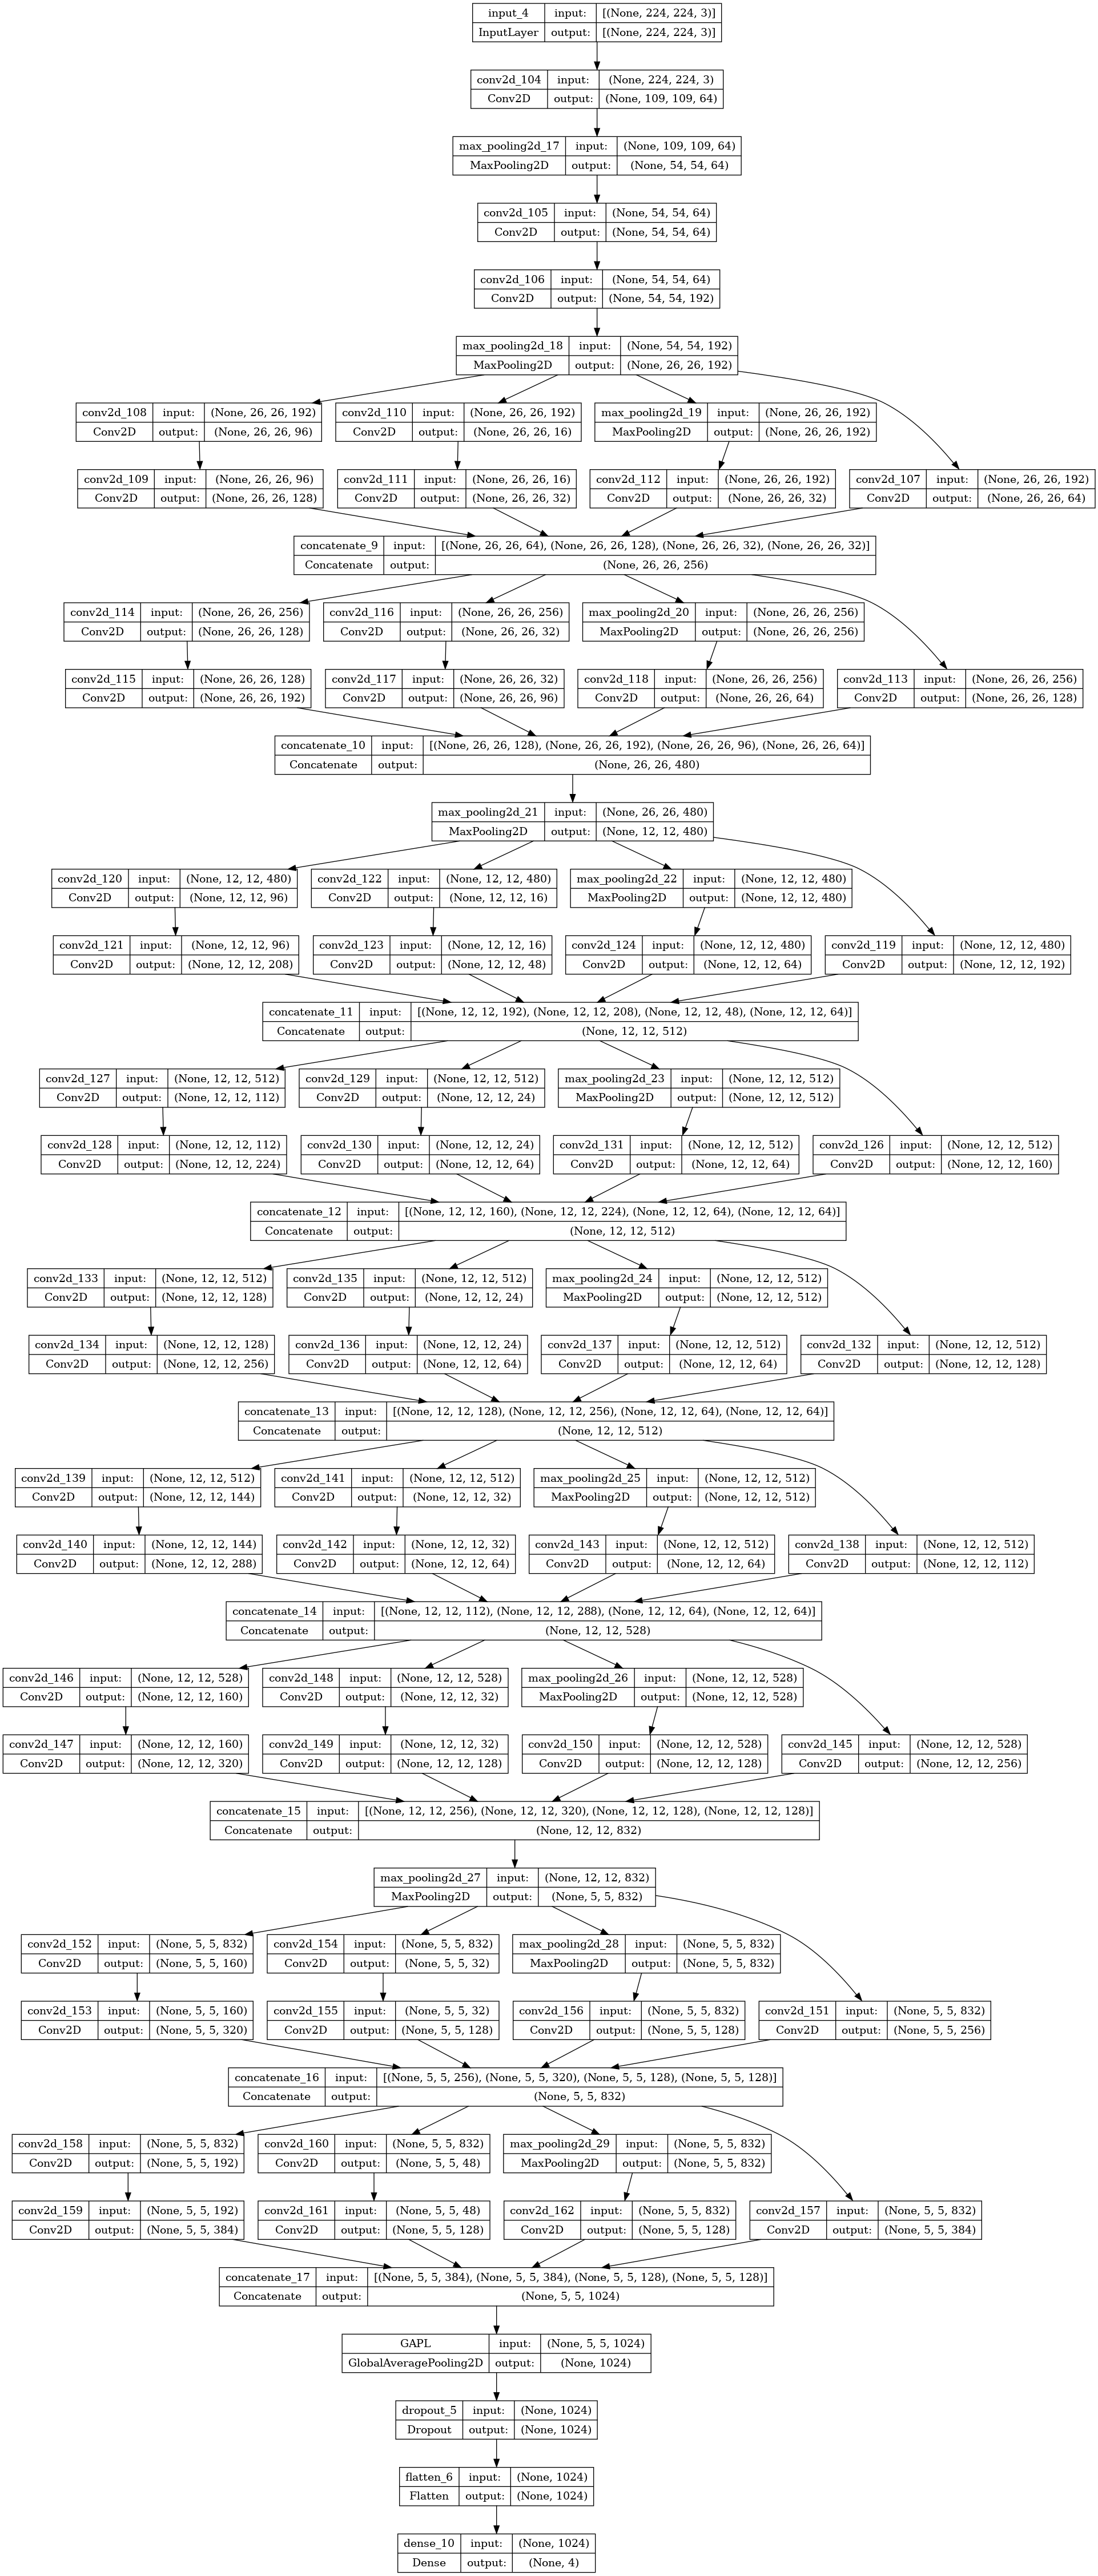

In [18]:
tf.keras.utils.plot_model(
    model2,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False,
)
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model2, to_file=dot_img_file, show_shapes=True)

In [35]:
# Compile the model
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history2=model2.fit(X_train, y_train,validation_data=(X_val,y_val),epochs=10, batch_size=50)

# Evaluate the model
result2 = model2.evaluate(X_test, y_test)
loss2 = result2[0]
accuracy2 = result2[1]
loss2, accuracy2 = model2.evaluate(X_test, y_test)

print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

Epoch 1/10
72/72 [==============================] - 31s 109ms/step - loss: 0.2434 - accuracy: 0.9116 - val_loss: 0.4952 - val_accuracy: 0.8164
Epoch 2/10
72/72 [==============================] - 7s 101ms/step - loss: 0.1954 - accuracy: 0.9261 - val_loss: 0.4285 - val_accuracy: 0.8490
Epoch 3/10
72/72 [==============================] - 8s 105ms/step - loss: 0.1352 - accuracy: 0.9517 - val_loss: 0.5344 - val_accuracy: 0.8392
Epoch 4/10
72/72 [==============================] - 7s 99ms/step - loss: 0.1544 - accuracy: 0.9411 - val_loss: 0.5400 - val_accuracy: 0.8457
Epoch 5/10
72/72 [==============================] - 7s 99ms/step - loss: 0.1372 - accuracy: 0.9495 - val_loss: 0.5549 - val_accuracy: 0.8451
Epoch 6/10
72/72 [==============================] - 7s 104ms/step - loss: 0.1258 - accuracy: 0.9526 - val_loss: 0.6001 - val_accuracy: 0.8607
Epoch 7/10
72/72 [==============================] - 8s 106ms/step - loss: 0.1551 - accuracy: 0.9453 - val_loss: 0.5720 - val_accuracy: 0.8372
Epoch 8

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


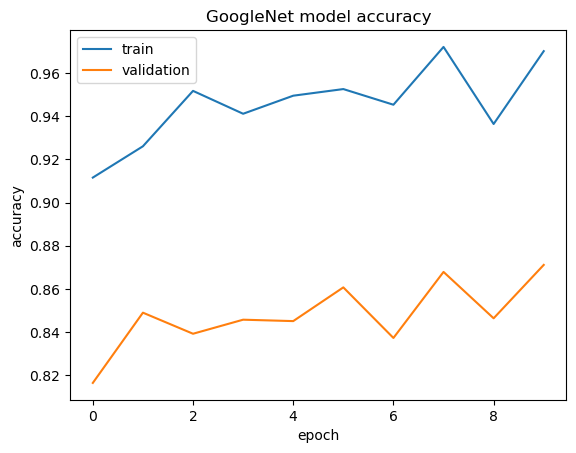

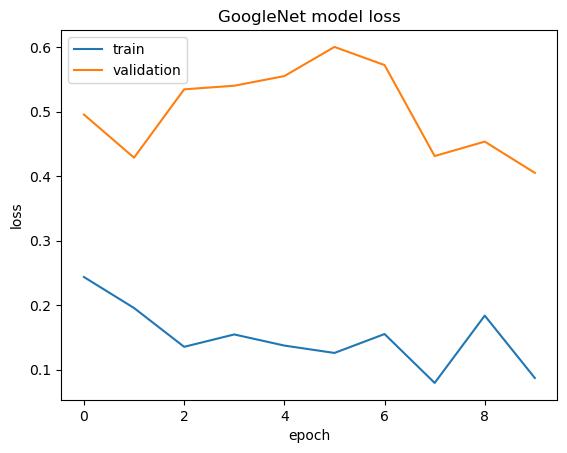

In [36]:
print(history2.history.keys())
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('GoogleNet model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('GoogleNet model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

40/40 [==============================] - 1s 20ms/step
Classification Report:
                     precision    recall  f1-score   support

     Mild_Demented       0.91      0.42      0.57       177
 Moderate_Demented       1.00      0.92      0.96        12
      Non_Demented       0.80      0.94      0.86       648
Very_Mild_Demented       0.77      0.74      0.75       443

          accuracy                           0.80      1280
         macro avg       0.87      0.75      0.79      1280
      weighted avg       0.81      0.80      0.79      1280



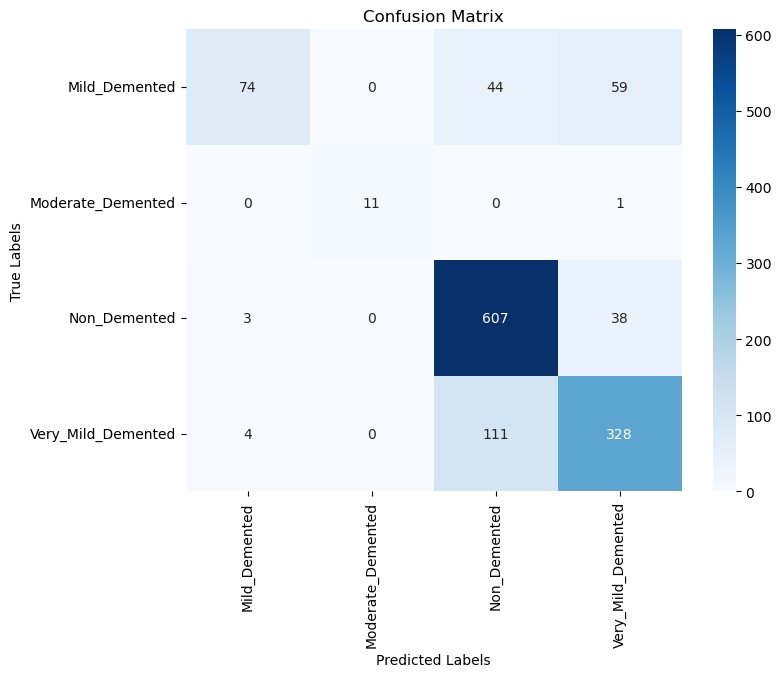

In [37]:
# Generate the classification report
class_names = list(['Mild_Demented','Moderate_Demented','Non_Demented','Very_Mild_Demented'])

# Generate the classification report
predictions2 = model2.predict(X_test)
predicted_classes2 = np.argmax(predictions2, axis=1)
report2 = classification_report(y_test, predicted_classes2, target_names=class_names)
print("Classification Report:\n", report)

# Generate the confusion matrix
cm2 = confusion_matrix(y_test, predicted_classes2 )
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

So here we got better result using GoogleNet architecture than ResNet architecture